## Data Exploration

### Import libraries

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import matplotlib.pyplot as plt

### General view of the dataset

In [2]:
df = pd.read_csv('spam_1.csv')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

There are `5572` data points and `5` columns: `v1`, `v2`, `Unnamed: 2`,	`Unnamed: 3`, `Unnamed: 4`


#### Drop `Unnamed: 2`,	`Unnamed: 3`, `Unnamed: 4` since they are irrelevant

In [5]:
# delete 3 unnamed columns
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

#### Rename `v1` to `Category` and `v2` to `Message`

In [6]:
df = df.rename(columns={"v1": "Label", "v2": "Message"})

In [7]:
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Check for missing values 

In [8]:
# check null
df.isnull().sum()

Label      0
Message    0
dtype: int64

#### Check for duplicates

In [9]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(5169, 2)

After dropping duplicates, the dataset goes from `5572` to `5169` rows

## Data preprocessing

### Remove special character

In [11]:
punctuation = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

In [12]:
df["Message"] = df["Message"].apply(lambda text: remove_punctuation(text))
df.head()

,Label,Message
0,ham,Go until jurong point crazy Available only in ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor U c already then say
4,ham,Nah I dont think he goes to usf he lives aroun...


### Remove stopwords

#### Install `nltk` (Natural Language Toolkit) 

In [13]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [14]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Function to remove stopwords

In [13]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

In [14]:
df["Message"] = df["Message"].apply(lambda text: remove_stopwords(text))
df.head()

,Label,Message
0,ham,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say early hor U c already say
4,ham,Nah I dont think goes usf lives around though


### Lemmatizing words

In [20]:
import nltk

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Function to lemmatize the text

In [15]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

# pos_text: Part of speech, assign a tag to each token in a document to denote its part of speech

wordnet_map = {"N":  wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    pos_text = pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_text])

In [16]:
df["Message"] = df["Message"].apply(lambda text: lemmatize_words(text))
df.head()

,Label,Message
0,ham,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say early hor U c already say
4,ham,Nah I dont think go usf life around though


### Check label's distribution of target vector `Category` to determine whether unbalanced or not

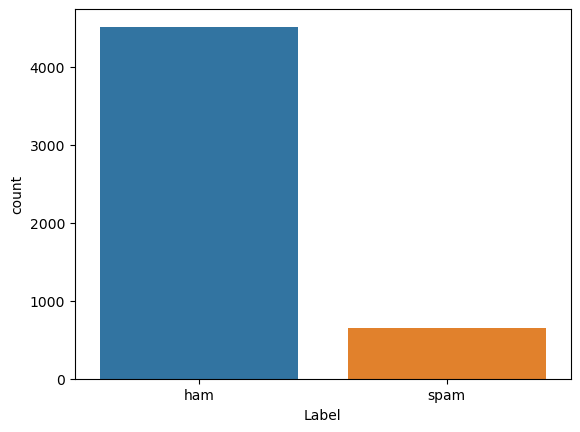

In [19]:
sns.countplot(x="Label", data=df)
plt.savefig('label_count')

In [159]:
df['Label'].value_counts()

Label
ham     4516
spam     653
Name: count, dtype: int64

The labels are unbalanced with **87%** are ham and **13%** are spam

## Split data

In [20]:
X = df['Message']
y = df['Label']

Since there's unbalanced in class lables, **stratified partitioning** will be used because it ensures that every partition preserves the same ratio of values for the prediction target as in the original data

In [25]:
from sklearn.model_selection import train_test_split

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4135,) (1034,) (4135,) (1034,)


## Training models

### Import models from scikit-learn

In [32]:
# base models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# meta model
from sklearn.ensemble import GradientBoostingClassifier

### Initialize TfidfVectorizer

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()

### Import  `Kfold`,  `cross_val_score`, `Pipeline`

In [34]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

### Create pipelines for base models and define baseline performance (training set) with `cross_val_score`

### Pipelines

In [35]:
# initialize LR model
lr = LogisticRegression()
lr_pl = Pipeline([('tf', TfidfVectorizer()), ('lr', lr)]) # initialize LR pipeline 

# initialize KNN model
knn = KNeighborsClassifier()
knn_pl = Pipeline([('tf', TfidfVectorizer()), ('knn', knn)]) # initialize KNN pipeline 

# initialize SVM model
svc = SVC()
svc_pl = Pipeline([('tf', TfidfVectorizer()), ('svc', svc)]) # initialize SVM pipeline 

# initialize NB model
nb = GaussianNB()
nb_pl = Pipeline([('tf', TfidfVectorizer()), ('nb', nb)]) # initialize NB pipeline 

# initialize RF model
rf = RandomForestClassifier()
rf_pl = Pipeline([('tf', TfidfVectorizer()), ('rf', rf)]) # initialize RF pipeline 

# initialize DT model
dt = DecisionTreeClassifier()
dt_pl = Pipeline([('tf', TfidfVectorizer()), ('dt', dt)])  # initialize DT pipeline 


In [49]:
pipelines = [lr_pl, knn_pl, svc_pl, rf_pl, dt_pl]

pipe_dict = {0: 'Logistic Regression', 1: 'K Nearest Neighbor', 2: 'Support Vector Machine',
             3: 'Random Forrest', 4: 'Decision Tree'
            }

In [ ]:
for i in range(len(pipelines)):
    score = cross_validate(pipelines[i], X_train, y_train,
                          cv=kfold, scoring='accuracy',
                          return_train_score=True)
    print(pipe_dict[i], '\n', score, '\n')

Logistic Regression 
 {'fit_time': array([0.34281921, 0.30503345, 0.28209639, 0.31796527, 0.29679918]), 'score_time': array([0.04750729, 0.03637171, 0.04429126, 0.0459404 , 0.04726672]), 'test_score': array([0.95042322, 0.97218863, 0.94316808, 0.95405079, 0.95405079]), 'train_score': array([0.95646917, 0.9525393 , 0.95737606, 0.95556227, 0.95737606])} 



In [47]:
# for NB
nb_test = GaussianNB()
X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)

X_train_tf_arr = X_train_tf.toarray()
X_test_tf_arr = X_test_tf.toarray()

nb_score = cross_validate(nb_test, X_train_tf_arr, y_train,
                          cv=kfold, scoring='accuracy',
                          return_train_score=True)

print('score', nb_score['train_score'])

score [0.95314389 0.94770254 0.95314389 0.96009674 0.95102781]


In [48]:
# lr_score = cross_validate(nb_pl, X_train, y_train,
#                           cv=kfold, scoring='accuracy',
#                           return_train_score=True)

# print('score', lr_score['train_score'])

In [44]:
# lr_score = cross_validate(lr_pl, X_train, y_train, 
#                           cv=kfold, scoring='accuracy',
#                           return_train_score=True)

# print('score', lr_score['train_score'])

# for reference
# for pipe in pipelines:
#   pipe.fit(X_train, y_train)
# for i,model in enumerate(pipelines):
#     print("{} Test Accuracy:{}".format(pipe_dict[i],model.score(X_test,y_test)))

score [0.95525998 0.95314389 0.95586457 0.95586457 0.95525998]


### Apply GridSearch to tune hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

### Get out-of-fold predictions for each tuned model

In [ ]:
# out-of-fold portion

### Model implementation using text data using tf-idf

In [134]:
# from sklearn.model_selection import KFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.pipeline import Pipeline
# import numpy as np

# # initialize tf-idf vectorizer
# # tf = TfidfVectorizer()

# lr = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5)

# text_clf = Pipeline([('tf', TfidfVectorizer()), ('lr', lr)])

# text_clf.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('lr',
                 LogisticRegression(l1_ratio=0.5, penalty='elasticnet',
                                    solver='saga'))])

In [137]:
# from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

# train_preds = text_clf.predict(X_train)
# score = accuracy_score(y_train, train_preds)
# score

0.9667938074938299

In [173]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# initialize tf-idf vectorizer
tf = TfidfVectorizer()

# initialize LR model
lr = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# initialize arrays to store predictions
full_y_pred = np.empty((0,))
full_holdout_pred = np.zeros(len(X_test))

y_train_text = np.array(y_train)

# tf-idf vectorized
X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)

# convert to array for easier
X_train_tf_arr = np.array(X_train_tf)
X_test_tf_arr = np.array(X_test_tf)


# create out-of-fold predictions for model stacking
for fold, (train_index, test_index) in enumerate(kfold.split(X_train_tf)):
    X_train_fold, X_test_fold = X_train_tf[train_index], X_train_tf[test_index]
    y_train_fold, y_test_fold = y_train_text[train_index], y_train_text[test_index]
    
    # fit model
    lr.fit(X_train_fold, y_train_fold)
    
    # make predictions on fold test and test sets
    y_fold_pred = lr.predict(X_test_fold)
    holdout_pred = lr.predict(X_test_tf)
    
    # extend full_y_pred with fold predictions
    full_y_pred = np.concatenate((full_y_pred, y_fold_pred))
    
    print(type(holdout_pred))
    
    # collect hold out predictions
#     full_holdout_pred += holdout_pred


<class 'numpy.ndarray'>


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('O') to dtype('float64') with casting rule 'same_kind'

In [168]:
full_y_pred

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype=object)

In [169]:
len(full_y_pred)

4135

In [ ]:
full_holdout_pred